# shot detection

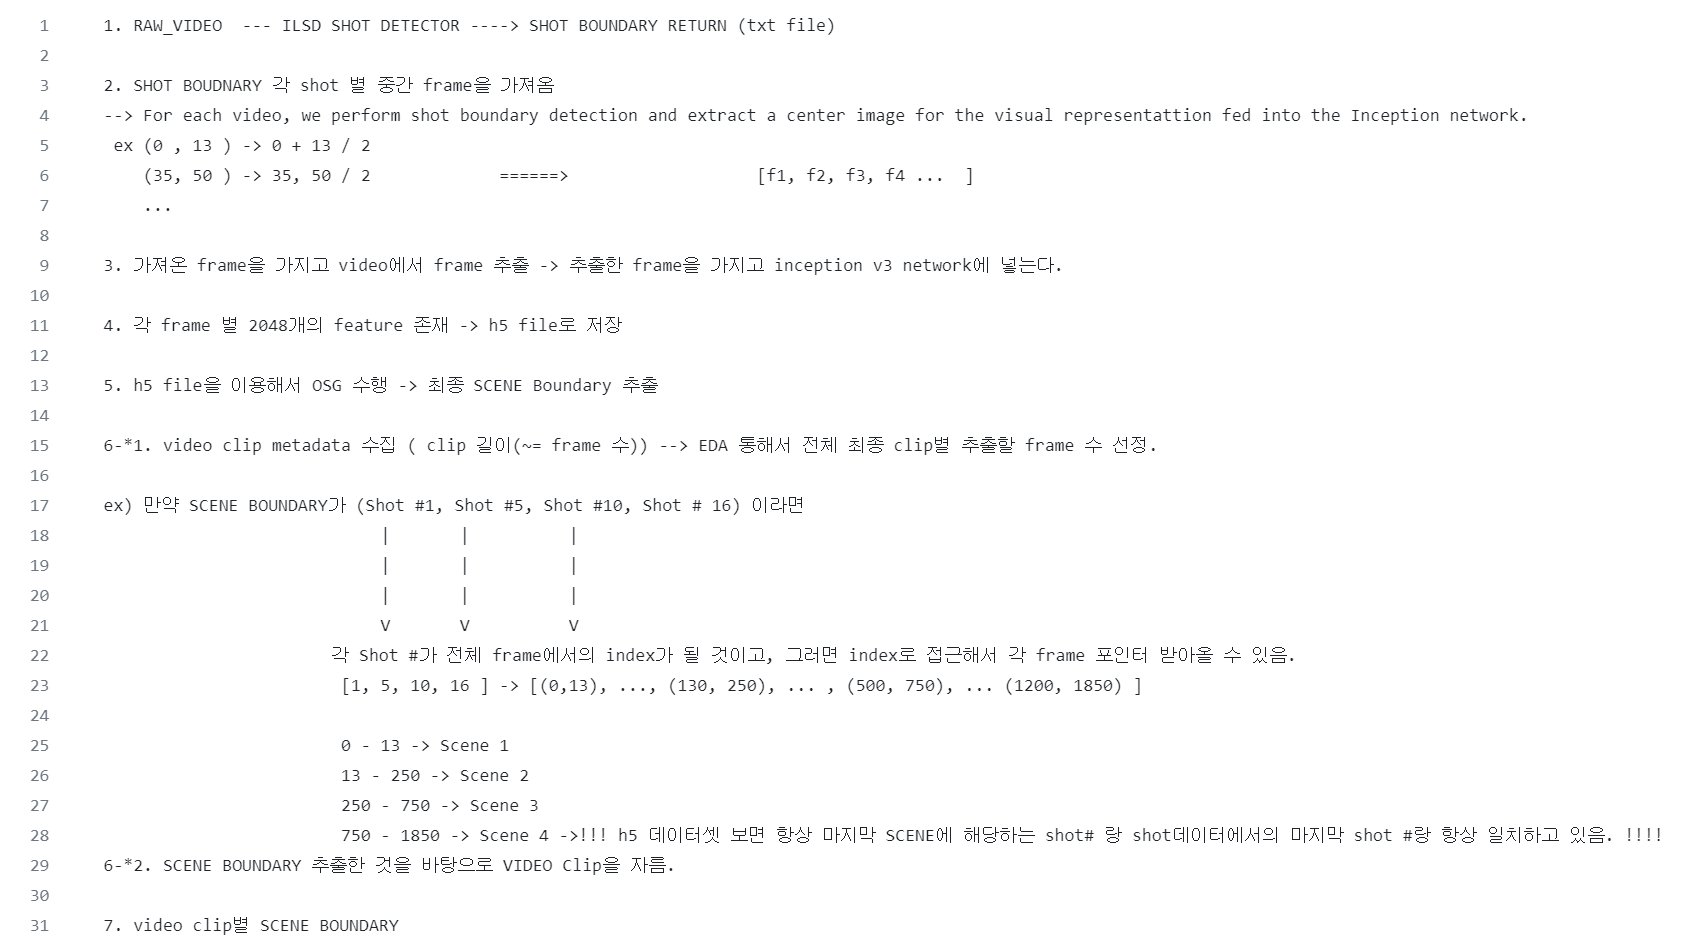

# 설정사항
1. ShotDetector Debug안에 video 폴더가 존재해야함.
2. 아래의 video 경로를 video가 있는 폴더로 지정하기

In [ ]:
import os
from tqdm import tqdm
import re

In [ ]:
# scene detection module 있는 곳으로 이동
os.chdir(r"E:\project_backup\ShotDetector\x64\Debug")
videos = os.listdir(r"E:\project_backup\ShotDetector\x64\Debug\news")

## config 설정

buffer_frame_size = 3

os.getcwd()

In [ ]:
# 경로 잘 받아오는지 확인용
videos[-1]

In [ ]:
# 특수문자가 존재할시 읽지 못하는 상황 발생하여 특수문자, 띄어쓰기를 정규식으로 제거.

base_dir = r"E:\project_backup\ShotDetector\x64\Debug\news\\"
for i in tqdm(videos):
    os.rename(base_dir + i , re.sub(' |’', '_', base_dir + i))

In [ ]:
# tqdm(videos) path를 바탕으로 shot detection 수행함.

for i in tqdm(videos):
    #print(path)
    path = "E:\\project_backup\\ShotDetector\\x64\\Debug\\news\\" + i
    os.system(f'ilsd {path} {buffer_frame_size}')

# scene detection 전처리과정

- qvhilight dataset(shot detection 후)
- youtube dataset

#### 1) shot detection 결과 전처리하기
video -> shot detection -> middle shot.txt 파일  
video의 shot 별 middle frame을 inception v3 모델에 돌려서 특징 추출  
특징 추출 -> h5파일로 만들어서 저장하기

In [ ]:
import torch
import PIL
import re
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import h5py
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import cv2
import av
import pickle
import torchvision
from torchvision import models
from torchvision.io import read_video
import pandas as pd

data 폴더 안에 있는 파일들 불러오기

In [ ]:
folder_path = "D:\youtube_data" # 폴더 경로 지정
file_list = os.listdir(folder_path) # 폴더 안에 있는 파일 목록
video_list = [file_name for file_name in file_list if file_name.endswith('.mp4')] # 비디오 목록 리스트
shot_list = [file_name for file_name in file_list if file_name.endswith('.txt')] # 샷 리스트 - 순서대로 저장 0-0
print(shot_list)
print(len(shot_list))

video 별로 middle shot list 저장하기

In [ ]:
middle_shots_dict = {}
for idx, n in enumerate(shot_list):
    shot_filepath = folder_path + '\\' + n
    shot = pd.read_csv(shot_filepath, header = None, delimiter='\t') # 처리
    shot['mid'] = round((shot[0] + shot[1])/2).astype(int) # 중간 frame 뽑아와
    shot['frame_cnt'] = shot[1]-shot[0] # frame 개수는 이거
    middle_shots = shot['mid'].tolist() # middle shot list
    middle_shots_dict[idx] = middle_shots
    #print(len(middle_shots))

print(middle_shots_dict)

get_video_frame 함수 정의

In [ ]:
def get_video_frame(video_path, frame_number):
    video = cv2.VideoCapture(video_path)

    if not video.isOpened():
        raise Exception("unable open the video")

    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_number > total_frames:
        raise Exception("FRAME NUMBER >>>> TOTAL FRAME!@!!")

    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    ret, frame = video.read()

    if not ret:
        raise Exception("프레임을 가져올 수 없음")

    video.release()

    return frame

In [ ]:
# list 안에 있는 img data 불러오기
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs):
        self.x_data = imgs
        self.transforms = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = cv2.resize(self.x_data[idx] , dsize=(299,299))
        x = cv2.normalize(x, None, 0, 1, cv2.NORM_MINMAX) # minmax_norm
        x = torch.FloatTensor(x)
        x = x.permute((2,0,1))
        tf = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 이미지 정규화
        x = tf(x)
        return x

In [ ]:
# video 별 feature 추출 -> h5 파일로 저장
imgs = []
feature_vectors =[] # 저장할라고 빈 리스트로 생성

for k,v in middle_shots_dict.items(): # 저장되어있는 middel_Shot # key 만큼 돌고,

    video_path = folder_path + '\\' + video_list[k]
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    for middle_shot_numbers in v: # v list 안에 하나하나 돌아서 -> middel shot number 불러옴
        img = get_video_frame(video_path, middle_shot_numbers) # 중간 프레임 뽑아와
        imgs.append(img)

    dataset = MyDataset(imgs=imgs) # dataset 가져오면서 전처리해주기
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
    model.eval()
    model.fc = torch.nn.Identity() # 입력 그대로 출력으로 반환 (항등함수)

    # GPU를 사용할 경우
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # 특성 벡터를 추출
    for images in dataloader:
        images = images.to(device)

        # forward  패스 # model의 출력을 계산하는 부분
        with torch.no_grad():
            features = model(images)

        feature_vectors.append(features.squeeze().cpu().numpy())

    # feature vector 저장
    for idx,features in enumerate(feature_vectors):
        features_np = np.array(features)
        print(f"frame {idx+1} features:", features_np)

    directory = "D:\Pycharm project\LearnableOSG\h5\youtube_h5"
    filename = f'{re.split(".mp4", video_list[k])[0]}.hdf5'

    os.makedirs(directory, exist_ok=True)
    file = h5py.File(os.path.join(directory,filename), "w") # h5 파일로 저장

    feature_vectors_np = np.stack(feature_vectors, axis=0)

    # 데이터셋 생성 및 데이터 저장
    dataset_name = "x"
    dataset = file.create_dataset(dataset_name, data=feature_vectors_np)

    # 각 feature vector의 이름을 속성으로 추가
    for idx, _ in enumerate(feature_vectors):
        dataset.attrs[str(idx)] = str(idx)

    # HDF5 파일 닫기
    file.close()


    #초기화
    imgs = []
    feature_vectors = []


## 2) scene detection 수행
- h5 file(x) -> scene detection -> h5 file(x,t)

scene detection model module화

In [ ]:
#dataset_loader(train).py

import torch
import torch.utils.data
import numpy as np
import re
from torch._six import container_abcs, string_classes, int_classes
import h5py

np_str_obj_array_pattern = re.compile(r'[SaUO]')



class OSG_VSD_DATASET(torch.utils.data.Dataset):
    def __init__(self, path_to_h5, device):
        self.path_to_h5 = path_to_h5
        self.device = device
        self.num_of_h5 = 3 # 51개 (hdf5 파일의 갯수만큼 지정해주기)


    def __len__ (self):
        return self.num_of_h5 # 파일 갯수만큼 길이 읽어오기

    def __getitem__(self, idx):
        the_file = h5py.File(self.path_to_h5+str(idx)+'.hdf5', 'r')
        return torch.tensor(the_file['x'], dtype=torch.float, device=self.device), torch.tensor(the_file['t'], dtype=torch.float, device=self.device)


def my_collate_old(batch):
    data = [item['x'] for item in batch]
    target = [item['t'] for item in batch]
    return [data, target]


my_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
"dicts or lists; found {}")

def my_collate(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""

    elem = batch[0]
    elem_type = type(elem)

    if isinstance(elem, torch.Tensor):
        out = None
        max_length = max([x.shape[0] for x in batch])
        numel = max_length*len(batch)
        storage = elem.storage()._new_shared(numel)
        out = elem.new(storage)
        return torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=-1)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(my_collate_err_msg_format.format(elem.dtype))

            return my_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int_classes):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, container_abcs.Mapping):
        return {key: my_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(my_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, container_abcs.Sequence):
        transposed = zip(*batch)
        return [my_collate(samples) for samples in transposed]

    raise TypeError(my_collate_err_msg_format.format(elem_type))


In [ ]:
#OptimalSequentialGrouping.py 
import numpy as np

class OptimalSequentialGrouping(object):
    """
    Segmentation class which performs optimal sequential grouping (OSG)
    """

    def ismember(self, A, B):
        '''
        배열 A의 각 요소가 배열 B에 포함되는지 여부를 반환함. A,B 모두 Numpy 배열로 입력
        '''
        return np.asarray([np.sum(a == B) for a in A]) # A의 요소가 B에 포함되면 1을 반환, 아니면 0을 반환

    def blockDivideDSum(self, D, K):
        """
        This method performs OSG using the sum objective function.
        :param D: input distance matrix
        :param K: number of blocks to divide the distance matrix into
        :return: the last index of each block
        """

        N = D.shape[0] # D의 행 크기

        # 오류 처리
        if N < 1 or K < 1 or N != D.shape[1]:
            print("Error: Problem with input.")
            return []

        if K > N:
            print("Warning: More scenes than shots. Returning shot boundaries.")
            return np.arrange(1, N + 1)

        if K == 1:
            return [N - 1]

        D_sum = OptimalSequentialGrouping.calcDSum(self, D) # calcDSum 메서드를 호출해서 D_sum을 계산한다. -> 주어진 D 배열을 기반으로, 거리합을 계산하는 과정

        C = np.zeros((N, K)) # 크기가 (N,K)인 0으로 채워진 배열
        I = np.zeros((N, K)) # 크기가 (N,K)인 0으로 채워진 배열 - 알고리즘의 중간 계산 결과 저장(중간 배열 초기화)

        # initialization
        for nn in range(0, N):
            C[nn, 0] = D_sum[nn, N - 1] # C 배열의 첫번째 열을 채우는 것
            I[nn, 0] = N - 1 # I 배열의 첫번째 열을 채우는 것

        # fill the rest
        for kk in range(1, K): # 알고리즘의 두 번째 열부터 마지막 열까지 업데이트
            for nn in range(0, N - kk): # 현재 처리 중인 블록의 첫번째 행부터 마지막 행까지 업데이트
                # T will hold the vector in which we're searching for a minimum
                T = np.transpose(D_sum[nn, nn:N - kk]) + C[nn + 1:N - kk + 1, kk - 1]
                I[nn, kk] = np.argmin(T)
                C[nn, kk] = T[int(I[nn, kk])]
                I[nn, kk] = I[nn, kk] + nn

        # prepare returned boundaries
        boundary_locations = np.zeros(K)
        the_prev = -1
        for kk in range(0, K):
            boundary_locations[kk] = I[int(the_prev + 1), K - kk - 1]
            the_prev = boundary_locations[kk]

        if the_prev != N - 1:
            print("Warning: Encountered an unknown problem.")

        return boundary_locations

    def blockDivide2DSum(self, D1, D2, K, metric='average'):
        """
        This method performs multimodal OSG using the sum objective function.
        :param D1: input distance matrix 1
        :param D2: input distance matrix 2
        :param K: number of blocks to divide the distance matrix into
        :param metric: method to decide on joint outcome (default 'average', other options 'min', 'max')
        :return: the last index of each block
        """

        N = D1.shape[0]

        if N < 1 or K < 1 or N != D1.shape[1] or N != D2.shape[0] or N != D2.shape[1]:
            print("Error: Problem with input.")
            return []

        if K > N:
            print("Warning: More scenes than shots. Returning shot boundaries.")
            return np.arrange(1, N + 1)

        if K == 1:
            return [N - 1]

        D1_sum = OptimalSequentialGrouping.calcDSum(self, D1)
        D2_sum = OptimalSequentialGrouping.calcDSum(self, D2)

        C1 = np.zeros((N, K))
        C2 = np.zeros((N, K))
        I = np.zeros((N, K))

        # initialization
        for nn in range(0, N):
            C1[nn, 0] = D1_sum[nn, N - 1]
            C2[nn, 0] = D2_sum[nn, N - 1]
            I[nn, 0] = N - 1

        # fill the rest
        for kk in range(1, K):
            for nn in range(0, N - kk):
                # T will hold the vector in which we're searching for a minimum
                T1 = np.transpose(D1_sum[nn, nn:N - kk]) + C1[nn + 1:N - kk + 1, kk - 1]
                C1[nn, kk] = np.min(T1)
                T2 = np.transpose(D2_sum[nn, nn:N - kk]) + C2[nn + 1:N - kk + 1, kk - 1]
                C2[nn, kk] = np.min(T2)

                if T1.size < 2:
                    I[nn, kk] = nn
                else:
                    if metric == 'average':
                        E = (T1 - np.mean(T1)) / np.std(T1) + (T2 - np.mean(T2)) / np.std(T2)
                    elif metric == 'min':
                        E = np.minimum((T1 - np.mean(T1)) / np.std(T1), (T2 - np.mean(T2)) / np.std(T2))
                    elif metric == 'max':
                        E = np.maximum((T1 - np.mean(T1)) / np.std(T1), (T2 - np.mean(T2)) / np.std(T2))
                    else:
                        print('Error. Unrecognized metric: ' + metric + '. Performing average.')
                        E = (T1 - np.mean(T1)) / np.std(T1) + (T2 - np.mean(T2)) / np.std(T2)

                    I[nn, kk] = np.argmin(E) + nn

        # prepare returned boundaries
        boundary_locations = np.zeros(K)
        the_prev = -1
        for kk in range(0, K):
            boundary_locations[kk] = I[int(the_prev + 1), K - kk - 1]
            the_prev = boundary_locations[kk]

        if the_prev != N - 1:
            print("Warning: Encountered an unknown problem.")

        return boundary_locations

    def calcDSum(self, D):
        """
        This method calculates the intermediate sums of D.
        :param D: input distance matrix
        :return: D_sum. A matrix which the value at (i,j) is the sum of the values in D from ii to jj
        """

        N = D.shape[0]

        D_sum = np.zeros((N, N))

        for oo in range(1, N):
            for ii in range(0, N - oo):
                D_sum[ii, ii + oo] = 2 * D[ii, ii + oo] + D_sum[ii, ii + oo - 1] + D_sum[ii + 1, ii + oo] - D_sum[
                    ii + 1, ii + oo - 1]
                D_sum[ii + oo, ii] = D_sum[ii, ii + oo]

        return D_sum

    def DFromX(self, x, dist_type='euclidean'):
        if dist_type == 'euclidean':
            return np.linalg.norm(x[:, None] - x, axis=2, ord=2)
        elif dist_type == 'cosine':
            x_corr = np.matmul(x, x.T)
            x_square = np.diag(x_corr)
            x_square_rows = np.repeat(x_square[:, None], x.shape[0], axis=1)
            x_square_cols = x_square_rows.T
            return (1.0 - x_corr / (np.sqrt(x_square_rows * x_square_cols) + 1e-8)) / 2.0
        else:
            print("unrecognized distance type")
            return None

    def PR(self, input, ground_truth):
        TP = np.intersect1d(input,ground_truth).size
        return TP / input.size, TP / ground_truth.size

    def FCO(self, input, ground_truth):
        num_shots = int(ground_truth[-1])+1
        num_scenes = ground_truth.size

        gt_scene_numbering = np.zeros(num_shots)
        new_scene_numbering = np.zeros(num_shots)
        gt_scene_number = 0
        new_scene_number = 0
        for shot_ind in range(num_shots):
            gt_scene_numbering[shot_ind] = gt_scene_number
            new_scene_numbering[shot_ind] = new_scene_number
            if shot_ind == ground_truth[gt_scene_number]:
                gt_scene_number += 1
            if shot_ind == input[new_scene_number]:
                new_scene_number += 1

        Ct = np.zeros(num_scenes)
        C = 0
        Ot = np.zeros(num_scenes)
        O = 0

        for scene_num in range(num_scenes):
            (_, _, counts) = np.unique(new_scene_numbering[gt_scene_numbering == scene_num], return_index=True, return_counts=True)
            if counts.size == 0:
                freq = 0
            else:
                freq = np.max(counts)
            Ct[scene_num] = freq/np.sum(gt_scene_numbering == scene_num)
            C += Ct[scene_num] * np.sum(gt_scene_numbering == scene_num)
            Ot[scene_num] = sum(self.ismember(new_scene_numbering,np.unique(new_scene_numbering[gt_scene_numbering == scene_num])) & self.ismember(gt_scene_numbering, [scene_num-1, scene_num+1]))/np.sum(self.ismember(gt_scene_numbering, [scene_num-1, scene_num+1]))
            O += Ot[scene_num] * np.sum(gt_scene_numbering == scene_num)

        C = C/num_shots
        O = O/num_shots

        F = 2*C*(1-O)/(C+1-O)

        return F, C, O

# input_D를 기반으로 장면의 개수(K)를 추정하는 함수.
    def estimate_num_scenes(self, input_D, D_t):
        if D_t is None: # D_t가 존재하지 않으면,
            D = input_D / input_D.max() # input_D를 최댓값으로 나눠서 정규화된 거리 행렬 'D'를 계산한다.
        else: # 그렇지 않으면, (D_t가 존재한다면,)
            D_t = np.where(input_D > 0.3, 1, 0)
            #sns.heatmap(D_t)
            #plt.show(D_t)
            D = np.multiply(D_t, input_D / input_D.max()) # D_t와 input_D를 곱한 후, input_D의 최댓값으로 나누어 'D'를 계산한다.
            #sns.heatmap(D)
            #plt.show(D)
        S = np.linalg.svd(D,compute_uv=False) # D의 SVD(특잇값 분해)를 수행하고, ->  S : singular values of D (특이값)
        the_graph = np.log(S[S>1.1]) # 특이값 중 1보다 큰 값에 대한 로그를 취한 배열(the_graph)를 생성한다. - 특이값은 기하급수적으로 감소하기 때문에 1보다 큰 특이값의 log를 계산한다.
        graph_length = len(the_graph) # the_graph의 길이 저장
        if graph_length < 2: # 길이가 2보다 작으면,
            return 1 # 장면의 개수는 1로 반환
        b = [graph_length - 1, the_graph[-1] - the_graph[0]] # 벡터 b를 계산 b = [그래프의 마지막 인덱스, (리스트의 마지막 값 - 첫번째 값의 차이)]
        b_hat = b / np.sqrt(b[0]**2 + b[1]**2) # b를 벡터의 크기로 나눈 정규화된 벡터 ?
        p = np.transpose(np.vstack((np.arange(0,graph_length),the_graph-the_graph[0]))) # (0, graph_length) 범위의 정수와 the_graph-the_graph[0]로 구성된 배열
        the_subt = p - np.transpose(np.vstack(((p*np.tile(b_hat, [graph_length, 1])).sum(1), (p*np.tile(b_hat, [graph_length, 1])).sum(1)))) * np.tile(b_hat,[graph_length, 1])
        the_dist = np.sqrt(the_subt[:, 0]**2 + the_subt[:, 1]**2) # the_subt의 첫번째 열과 두 번째 열의 제곱을 더한 후, 제곱근을 취한 결과
        the_elbow = np.nonzero(the_dist==np.max(the_dist))[0][0] # 최댓값과 동일한 값의 인덱스를 찾고, 첫번째 인덱스를 the_elbow로 저장
        return the_elbow + 1 # 장면의 개수를 반환

In [ ]:
#OSG_SVD.py
import torch
import numpy as np

def my_Tloss(input_prediction_stack,input_groundtruth_stack, device=torch.device("cuda")):
    total_loss = 0
    input_prediction_list = input_prediction_stack.unbind()
    input_groundtruth_list = input_groundtruth_stack.unbind()
    for the_ind in range(len(input_prediction_list)):
        input_prediction, input_groundtruth = input_prediction_list[the_ind], input_groundtruth_list[the_ind]
        T_pred = torch.masked_select(input_prediction, ~torch.isnan(input_prediction))
        t = torch.masked_select(input_groundtruth, ~torch.isnan(input_groundtruth))
        T_gt = torch.zeros(int(t[-1]), device=device)
        for scene_end in t[:-1]:
            T_gt[int(scene_end)] = 1
        total_loss = total_loss + torch.masked_select(T_pred[:-1], T_gt.ge(1)).clamp(min=1e-3).log().neg().sum()
    return total_loss

class DIST(torch.nn.Module):
    def __init__(self, feature_sizes, BN=False, DO=0.0, dist_type='EMBEDDING', dist_metric='cosine', device=torch.device("cuda")):
        super(DIST, self).__init__()
        self.device = device
        self.feature_sizes =feature_sizes
        self.activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(DO)
        self.network = torch.nn.Sequential()
        for layer_num in range(0, len(feature_sizes)-1):
            self.network.add_module('FC'+str(layer_num),torch.nn.Linear(feature_sizes[layer_num], feature_sizes[layer_num+1]))
            if isinstance(BN, list):
                if BN[layer_num]:
                    self.network.add_module('BN'+str(layer_num),torch.nn.BatchNorm1d(feature_sizes[layer_num+1]))
            else:
                if BN:
                    self.network.add_module('BN'+str(layer_num),torch.nn.BatchNorm1d(feature_sizes[layer_num+1]))
            if layer_num < len(feature_sizes)-2:
                self.network.add_module('ACT'+str(layer_num),self.activation)
                if DO > 0.0:
                    self.network.add_module('DO' + str(layer_num),self.dropout)
        self.dist_type = dist_type
        self.dist_metric = dist_metric

    def forward(self, input_x):
        if list(input_x.shape)[0] > 1:
            print('Warning - expected batch size 1')
        x = input_x.squeeze(0)

        if self.dist_type == 'DIST':
            x_new = torch.cat((x.repeat(x.shape[0],1),x.repeat(1,x.shape[0]).view(x.shape[0]*x.shape[0],-1)),1)
        elif self.dist_type == 'EMBEDDING':
            x_new = x
        else:
            print('Warning - unrecognized dist_type. Performing EMBEDDING.')
            x_new = x

        x_new = self.network(x_new)

        if self.dist_type=='EMBEDDING':
            if self.dist_metric=='cosine':
                x_new_corr = x_new.matmul(x_new.t())
                x_new_square = torch.masked_select(x_new_corr, torch.eye(x_new.shape[0], device=self.device).ge(1))
                x_new_square_rows = x_new_square[:, None].repeat(1, x_new.shape[0])
                x_new_square_cols = x_new_square.t().repeat(x_new.shape[0], 1)
                D = (1.0 - x_new_corr / (x_new_square_rows * x_new_square_cols).clamp(min=1e-8).sqrt()) / 2.0
            elif self.dist_metric=='euclidean':
                D = torch.norm(x_new[:, None] - x_new, dim=2, p=2)
            else:
                print('Warning - unrecognized dist_metric. Performing euclidean.')
                D = torch.norm(x_new[:, None] - x_new, dim=2, p=2)
        elif self.dist_type=='DIST':
            D = x_new.view(x.shape[0],-1)

        D.unsqueeze_(0)
        return D


class D_SUM_CALC(torch.nn.Module):
    def __init__(self, device=torch.device("cuda")):
        super(D_SUM_CALC, self).__init__()
        self.device = device
    def forward(self, input_D):
        if list(input_D.shape)[0] > 1:
            print('Warning - expected batch size 1')
        D = input_D.squeeze(0)
        N = list(D.shape)[0]
        D_sum = torch.zeros(N,N, device=self.device)
        # diagonal
        for ii in range(N):
            D_sum[ii,ii] = D[ii,ii]
        # second diagonal
        for ii in range(0, N-1):
            D_sum[ii, ii+1] = D[ii:ii+1+1, ii:ii+1+1].sum()
            D_sum[ii+1, ii] = D[ii, ii+1]
        # rest
        for oo in range(2, N):
            for ii in range(0, N - oo):
                D_sum[ii, ii + oo] = D[ii, ii + oo] + D[ii + oo, ii] + D_sum[ii, ii + oo - 1] + D_sum[ii + 1, ii + oo] - D_sum[ii + 1, ii + oo - 1]
                D_sum[ii + oo, ii] = D_sum[ii, ii + oo]
        D_sum.unsqueeze_(0)
        return D_sum

class C_TABLE_ALL(torch.nn.Module):
    def __init__(self, K, device=torch.device("cuda")):
        super(C_TABLE_ALL, self).__init__()
        self.K = K
        self.device = device
    def forward(self, input_D_sum):
        if list(input_D_sum.shape)[0] > 1:
            print('Warning - expected batch size 1')
        D_sum = input_D_sum.squeeze(0)
        N = list(D_sum.shape)[0]
        K = self.K
        C = torch.zeros(N, K, device=self.device)
        C_all = -1 * torch.ones(N, K, N, device=self.device)
        the_softmin = torch.nn.Softmin(dim=0)
        for nn in range(N):
            C[nn, 0] = D_sum[nn, N-1]
            C_all[nn, 0, N-1] = 1.0
        for kk in range(1, K):
            for nn in range(0, N - kk):
                temp = torch.empty(N - kk - nn, device=self.device)
                for ii in range(nn, N - kk):
                    temp[ii-nn] = D_sum[nn, ii] + C[ii + 1, kk - 1]
                C_all[nn, kk, nn:N-kk] = the_softmin(temp)
                C[nn, kk] = torch.min(temp)
        C.unsqueeze_(0)
        C_all.unsqueeze_(0)
        return C, C_all

class OSG_C(torch.nn.Module):
    def __init__(self, feature_sizes, K_max=30, BN=False, DO=0.0, dist_type='EMBEDDING', dist_metric='cosine', device=torch.device("cuda")):
        super(OSG_C, self).__init__()
        self.feature_sizes = feature_sizes
        self.K_max = K_max
        self.DIST_FUNC = DIST(feature_sizes,BN,DO,dist_type,dist_metric, device)
        self.D_SUM_CALC = D_SUM_CALC(device)
        self.C_TABLE_ALL = C_TABLE_ALL(K_max, device)
        self.device = device
        self.state_dict() # 내가 추가해줌

    def forward(self, x): # input tensor 'x'를 인자로 받음
        T_list = list()
        if len(x.shape) == 2: # x의 shape이 2개의 차원으로 이루어져 있다면,
            x.unsqueeze_(0) # 하나의 샘플만 있는 경우이므로 배치 차원을 추가하기 위해 차원을 확장해준다.
        for x_input in x.unbind(): # x는 루프를 통해 반복된다.
            x_input = torch.masked_select(x_input, ~torch.isnan(x_input)).view(1, -1, x_input.shape[1])
            D = self.DIST_FUNC(x_input) # 거리 매트릭을 계산
            D_sum = self.D_SUM_CALC(D) # 거리 합 계산
            __, C_all = self.C_TABLE_ALL(D_sum) # 0보다 큰 값들을 선택해 평균을 계산, T_PRED_ALL에 저장
            T_pred_all = torch.zeros(C_all.shape[3], device=self.device)
            for ind in range(C_all.shape[3]):
                T_pred_all[ind] = torch.masked_select(C_all[0, :, :, ind], C_all[0, :, :, ind].ge(0)).mean()
            the_padding = torch.nn.modules.padding.ConstantPad1d((0, x.shape[1] - T_pred_all.shape[0]), float('nan')) # 패딩 추가
            T_list.append(the_padding(T_pred_all)) # 패딩된 t_pred_all을 추가
        T_out = torch.stack(T_list)

        return T_out


In [ ]:
#osg_vsd_train.py

import torch
#import OSG_VSD as OSG
#import my_Tloss
#import OSG_C
import numpy as np
np.set_printoptions(linewidth=300)
#import OSG_VSD_DATASET
#import OptimalSequentialGrouping
from tqdm import tqdm


# 더 학습시키고 싶으면, stop_param 값을 낮춰주면 됨.
def CLossTest(data_folder_path="D:\Pycharm project\LearnableOSG\h5", modality= 'visual', num_iters=1, stop_param=0.75):
    if modality == 'visual':
        path_to_h5 = data_folder_path + '/h5_visual/'
        d, K_max = 2048, 5
        BN = True
        DO = 0.0
        dist_metric = 'cosine'
        dist_type = 'EMBEDDING'
        feature_sizes = [d, 3000, 3000, 1000, 100]
        learning_rate = 0.005
        weight_decay = 0  # 1e-2
    elif modality == 'audio':
        path_to_h5 = data_folder_path + 'h5_audio/'
        d, K_max = 128, 5
        BN = True
        DO = 0.0
        dist_metric = 'cosine'
        dist_type = 'EMBEDDING'
        feature_sizes = [d, 200, 200, 100, 20]
        learning_rate = 0.005
        weight_decay = 0  # 1e-2

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cuda")

    vsd_dataset = OSG_VSD_DATASET(path_to_h5=path_to_h5, device=device)

    vsd_dataloader = torch.utils.data.DataLoader(vsd_dataset, collate_fn=my_collate)

    OSG_model = OSG_C(feature_sizes, K_max=K_max, BN=BN, DO=DO, dist_type=dist_type, dist_metric=dist_metric,
                          device=device)

    OSG_model.to(device)

    optimizer = torch.optim.Adam(OSG_model.parameters(), lr=learning_rate, weight_decay=weight_decay) # 모델의 파라미터를 최적화

    print('Starting')
    print('network', feature_sizes, 'dist_type', dist_type, 'dist_metric', dist_metric, 'stop_param', stop_param,
          'modality', modality)

    first_loss = 0
    for iteration in tqdm(range(num_iters)):
        optimizer.zero_grad()
        all_loss = 0

        for a_batch in tqdm(vsd_dataloader, leave=False):
            x, t = a_batch
            T_pred = OSG_model(x.to(device))
            loss = my_Tloss(T_pred.to(device), t.to(device), device=device)
            all_loss += loss.item()
            loss.backward()

        if iteration == 0:
            first_loss = all_loss

        optimizer.step()

        OSG_np = OptimalSequentialGrouping() # OSG 모델의 출력값을 기반으로 클러스터링 수행

        F_trn = 0
        for an_index in range(len(vsd_dataset)):
            x_orig, t_orig = vsd_dataset[an_index]
            t = t_orig.cpu().numpy()
            D_temp = OSG_model.DIST_FUNC(x_orig.unsqueeze(0))
            D_new = D_temp.squeeze(0).cpu().detach().numpy()
            boundaries_new = OSG_np.blockDivideDSum(D_new, t.size)
            F_temp, _, _ = OSG_np.FCO(boundaries_new, t)
            F_trn += F_temp

        print('Iteration ' + str(iteration+1) + ', loss: ' + str(all_loss) + ', F-score: ' + str(F_trn)) # F-Score 품질

        if all_loss < stop_param * first_loss:
            break

    print('Finished')
    torch.save(OSG_model.state_dict(), 'model_param7.pth')  # model.pth 저장해주기 위한 코드

if __name__ == "__main__":
    CLossTest(num_iters=1)

In [ ]:
#dataset_loader(inference).py
import torch
import torch.utils.data
import numpy as np
import re
from torch._six import container_abcs, string_classes, int_classes
import h5py
import os

np_str_obj_array_pattern = re.compile(r'[SaUO]')



class OSG_VSD_DATASET(torch.utils.data.Dataset):
    def __init__(self, path_to_h5, device):
        self.path_to_h5 = path_to_h5 # h5_new/h5_visual 경로로 설정
        self.device = device
        self.h5_files = [f.split('.hdf5')[0] for f in os.listdir(path_to_h5) if f.endswith('.hdf5')] # 폴더 안에 있는 hdf5들의 리스트를 저장
        print("파일 목록:",self.h5_files, "파일 개수", len(self.h5_files))
        self.num_of_h5 = len(self.h5_files) # 몇개씩 받아올거냐

    def __len__(self):
        # Implement the logic to determine the number of samples in the dataset
        return self.num_of_h5

    def __getitem__(self, idx):
        the_file = h5py.File(self.path_to_h5 + self.h5_files[idx] + '.hdf5', 'r')
        x_data = torch.tensor(the_file['x'], dtype=torch.float, device=self.device)

        if x_data.shape[0] <= 1:
            return None  # None 값을 반환
        return x_data


def my_collate_old(batch):
    data = [item['x'] for item in batch]
    target = [item['t'] for item in batch]
    return data
    #return [data, target]


my_collate_err_msg_format = (
    "default_collate: batch must contain tensors, numpy arrays, numbers, "
"dicts or lists; found {}")

def my_collate(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""

    elem = batch[0]
    elem_type = type(elem)

    if isinstance(elem, torch.Tensor):
        out = None
        max_length = max([x.shape[0] for x in batch])
        numel = max_length*len(batch)
        storage = elem.storage()._new_shared(numel)
        out = elem.new(storage)
        return torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=-1)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(my_collate_err_msg_format.format(elem.dtype))

            return my_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(elem, int_classes):
        return torch.tensor(batch)
    elif isinstance(elem, string_classes):
        return batch
    elif isinstance(elem, container_abcs.Mapping):
        return {key: my_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(my_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, container_abcs.Sequence):
        transposed = zip(*batch)
        return [my_collate(samples) for samples in transposed]

    raise TypeError(my_collate_err_msg_format.format(elem_type))


In [ ]:
#inference.py
import h5py
import torch
#import OSG_VSD as OSG
import numpy as np
np.set_printoptions(linewidth=300)
#import osg_vsd_dataset_test
#import OptimalSequentialGrouping
from tqdm import tqdm
import os
import re

def inference(data_folder_path='D:\Pycharm project\LearnableOSG\h5\youtube_h5_x/', modality='visual', model_path='model.pth', result_path='result', num_iters=1, stop_param=0.75):
    if modality == 'visual':
        path_to_h5 = data_folder_path #+ 'h5_visual/'
        h5_files = [f.split('.hdf5')[0] for f in os.listdir(path_to_h5) if f.endswith('.hdf5')]
        print("파일 개수", len(h5_files))
        d, K_max = 2048, 5
        BN = True
        DO = 0.0
        dist_metric = 'cosine'
        dist_type = 'EMBEDDING'
        feature_sizes = [d, 3000, 3000, 1000, 100]
        learning_rate = 0.005
        weight_decay = 0  # 1e-2
#    elif modality == 'audio':
#        path_to_h5 = data_folder_path + 'h5_audio/'
#        d, K_max = 128, 5
#        BN = True
#        DO = 0.0
#        dist_metric = 'cosine'
#        dist_type = 'EMBEDDING'
#        feature_sizes = [d, 200, 200, 100, 20]
#        learning_rate = 0.005
#        weight_decay = 0  # 1e-2


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("cuda")

    vsd_dataset = OSG_VSD_DATASET(path_to_h5=path_to_h5, device=device)

    vsd_dataloader = torch.utils.data.DataLoader(vsd_dataset, collate_fn=my_collate)

    OSG_model = OSG_C(feature_sizes, K_max=K_max, BN=BN, DO=DO, dist_type=dist_type, dist_metric=dist_metric, device=device).to(device) # 모델 초기화

    checkpoint = torch.load('model_param7.pth',map_location='cuda:0')
    OSG_model.load_state_dict(checkpoint)

    #OSG_model.to(device)


    # optimizer = torch.optim.Adam(OSG_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    print('Starting')
    print('network', feature_sizes, 'dist_type', dist_type, 'dist_metric', dist_metric, 'stop_param', stop_param, 'modality', modality)

    first_loss = 0

    # 경계를 저장할 리스트
    all_boundaries = []



    # for iteration in tqdm(range(num_iters)):
    #     optimizer.zero_grad()
    #     #all_loss = 0
    # 
    #     for a_batch in tqdm(vsd_dataloader, leave=False):
    #         x = a_batch
    #         #x, _ = a_batch
    #         # T_pred = OSG_model(x.to(device)) # OSG Model에 배치를 입력하여, T_pred 값을 예측한다.
    #         #print(T_pred)
    #         #loss = OSG.my_Tloss(T_pred.to(device), t.to(device), device=device) # loss 값 계산
    #         #all_loss += loss.item()
    #         #loss.backward() # loss를 역전파하고 모델의 파라미터를 업데이트
    # 
    # 
    #     #if iteration == 0:
    #         #first_loss = all_loss
    # 
    #     optimizer.step()
    # 
    OSG_np = OptimalSequentialGrouping()
    #     # print(f"OSG_NP : {OSG_np}") # 얘가 원하는 결과값
    # 
    #     F_trn = 0
    for an_index in range(len(vsd_dataset)):
        print(f"index : {an_index}")

        #x_orig, t_orig = vsd_dataset[an_index]
        x_orig = vsd_dataset[an_index]
        if x_orig == None:
            continue
        x_orig = x_orig.to(device) # x 값

        #t = t_orig.cpu().numpy()
        D_temp = OSG_model.DIST_FUNC(x_orig.unsqueeze(0)) # x_orig을 입력값으로 받아서 거리행렬 D를 만들어
        D_new = D_temp.squeeze(0).cpu().detach().numpy()
        # D_temp = D_temp.to(device)
        #
        # D_temp_np = D_temp.cpu().detach().numpy()
        K_pred = OSG_np.estimate_num_scenes(D_new,D_new)
        #K_pred = K_pred.to(device)
        print(f"K_predicted:{K_pred}")
        boundaries_new = OSG_np.blockDivideDSum(D_new, K_pred) # t.size 값(= 장면의 수)를 받아서 경계를 출력한다.
        t_data=boundaries_new # t dataset 생성
        print(f"BOUNDARY_{an_index} : {boundaries_new}")
        #F_temp, _, _ = OSG_np.FCO(boundaries_new, t)
        #F_trn += F_temp

        # 경계와 씬 번호를 리스트에 추가
        #all_boundaries.append((an_index, boundaries_new))
        file_name = os.path.join(path_to_h5, f'{h5_files[an_index]}.hdf5')
        print("inference file name:", file_name)
        with h5py.File(file_name, 'a') as h5_file:
            #h5_file.create_dataset('t', data=t_data)
            if 't' in h5_file.keys():
                del h5_file['t']
            h5_file.create_dataset('t', data=t_data)

    #print('Iteration ' + str(iteration) + ', F-score: ' + str(F_trn))

    #if all_loss < stop_param * first_loss:
    #        break

    print('Finished')

    # 'result' 폴더 생성
    os.makedirs(result_path, exist_ok=True)

    # 경계를 파일에 저장
    #with open(os.path.join(result_path, 'boundaries_test.txt'), 'w') as f:
    #    for scene_index, boundaries in all_boundaries:
    #        f.write('Video ' + str(scene_index) + ', Boundaries: ' + ', '.join(str(boundary) for boundary in boundaries) + '\n')

    # 결과 파일 경로 설정
#    with open(os.path.join(result_path, 'result.txt'), 'w') as f:
#        f.write('F-score: ' + str(F_trn))

if __name__ == "__main__":
    inference()


## 3) scene detection 후, raw video -> scene 별로 자르기
- mmv model video input 전처리과정

In [ ]:
import pandas as pd
import h5py
import os
import re

class VideoSceneAnalyzer:
    def __init__(self):
        self.vid = {}

    def read_shot_file(self, shot_filepath): # shot.txt 파일올 읽어들여서 shot, mid, frame_cnt 출력
        # print("def : read_shot_file", shot_filepath)
        shot = pd.read_csv(shot_filepath, header=None, delimiter='\t')
        shot['mid'] = round((shot[0] + shot[1]) / 2).astype(int)
        shot['frame_cnt'] = shot[1] - shot[0]
        mid = round((shot[0] + shot[1]) / 2).astype(int).tolist()
        frame_cnt = (shot[1] - shot[0]).tolist()
        return shot, mid, frame_cnt

    def read_hdf5_file(self, h5_filepath):
        # print(h5_filepath)
        # return [2,3,4,5]
    # h5 파일 읽어오기 -> scene_boundary
        file = h5py.File(h5_filepath, 'r')
        dataset = file['t']
        scene_boundary = dataset[()].astype(int) # 데이터 셋을 가져온 후, int 형태로 변환
        file.close()
        #print(type(scene_boundary))
        #print(scene_boundary.shape)
        #print(scene_boundary)
        return scene_boundary # scene_boundary를 반환


    def frame_in_scene(self, scene_boundary, frame_cnt): # scene 안에 frame 수 계산
        n = len(scene_boundary) # n = scene의 개수
        #print("scene의 개수",n)
        cnt = {}

        for i in range(n): # 한 scene을 돌면서
            total_sum = 0

            try:
                if i == 0: # 처음 돌면,
                    r = range(0, scene_boundary[i])
                else:
                    r = range(scene_boundary[i-1], scene_boundary[i])

                for j in r:
                    total_sum += frame_cnt[j] # 프레임의 총 갯수

                cnt['scene'+str(i)] = total_sum # 씬마다 씬에 해당하는 총 프레임 수 계산
            except IndexError:
                print(f"IndexError occurred for scene boundary {i}, skipping...")

        return cnt # 딕셔너리 형태 {'scene i': frame의 총 개수}

    def analyze_video_scene(self, shot_filepath, h5_filepath):
        shot_data, mid, frame_cnt = self.read_shot_file(shot_filepath)
        scene_boundary = self.read_hdf5_file(h5_filepath)

        shot_filename = os.path.basename(shot_filepath).split("\\")[-1].replace("_shots.txt", "") # 파일 이름 추출
        #print(shot_filename)
        self.vid[shot_filename] = self.frame_in_scene(scene_boundary, frame_cnt)

    def get_video_scene(self):
        return self.vid


In [ ]:
analyzer = VideoSceneAnalyzer()

base_path = r"D:\youtube_data"

shot_txt_files = [f for f in os.listdir(base_path) if f.endswith('.txt')]
hdf5_files = [f for f in os.listdir(base_path + "\\h5_1") if f.endswith('.hdf5')]

for idx in range(len(shot_txt_files)):
    shot_txt_path = os.path.join(base_path+ "\\" ,shot_txt_files[idx])
    hdf5_path = os.path.join(base_path + "\\h5_1", hdf5_files[idx])
    analyzer.analyze_video_scene(shot_txt_path, hdf5_path)

video_scenes = analyzer.get_video_scene()
print(video_scenes)

In [ ]:
import pandas as pd
df=pd.DataFrame(video_scenes).T
df

In [ ]:
df.to_csv(r'D:\youtube_data\dataframe\model_param7.csv', encoding='utf-8')

In [ ]:
import os
import cv2
import pandas as pd

df = pd.read_csv(r"D:\youtube_data\dataframe\model_dropout_weight_decay2.csv")
df

In [ ]:
# 비디오 + 오디오 -> scene 별로 저장
import subprocess

baseUrl = r"D:\qvhilights_videos\videos"

for i in range(len(df['Unnamed: 0'])):
    video_name = df.iloc[i][0]
    path = baseUrl + "\\" + video_name + ".mp4" # input video path, mp4만 있다고 가정
    frame_list = []
    for j in range(df.shape[1]):
        if not(pd.isna(df.iloc[i][j])):
            frame_list.append(df.iloc[i][j])
    print(f"frame_list {i}", frame_list)

    video_capture = cv2.VideoCapture(path) # input video capture
    fps = video_capture.get(cv2.CAP_PROP_FPS) # 현재 동영상의 fps 가져오기
    video_capture.release()

    output_folder = os.path.join(r"D:\test", video_name) # output video path
    os.makedirs(output_folder, exist_ok=True)

    start_frame = 0
    i_current_frame = 0 # 현재 프레임 순서를 나타내는 변수
    for frame in frame_list[1:]:
        output_path = os.path.join(output_folder, f"{video_name}_{start_frame}.mp4")
        last_frame = int(frame) + i_current_frame - 1
        print("frame:", frame)

        command = [
            "ffmpeg",
            "-ss", str(start_frame/fps),
            "-i", path,
            "-t", str(int(frame)/fps),
            "-c:v", "libx264",
            "-c:a", "aac",
            "-strict", "-2",
            output_path
        ]
        subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        print("start frame:", start_frame, "last frame:", last_frame)
        start_frame = last_frame + 1
        print("씬 별 총 프레임 개수:", i_current_frame)

    i_current_frame = 0 #초기화

print("최종 끝")
